In [9]:
# Example usage:
from invasion import (
    compute_nontrivial_slice,
    simulate_segment,
    compute_deltaW_curve,
    compare_severities,
    test_plot,
    compare_scalers,
    run_cycles,
    run_cycles_ext
)

W_birth = 0.4
W_death = 0.1
Y_birth = 0.9
Y_death = 0.15

X_in = 0.2
X_out = 0.1
Z_in = 0.5
Z_out = 0.25

Time = 600.0
dt = 0.1

use_X = True
use_Z = False

num_points = 100
severity = 0.5

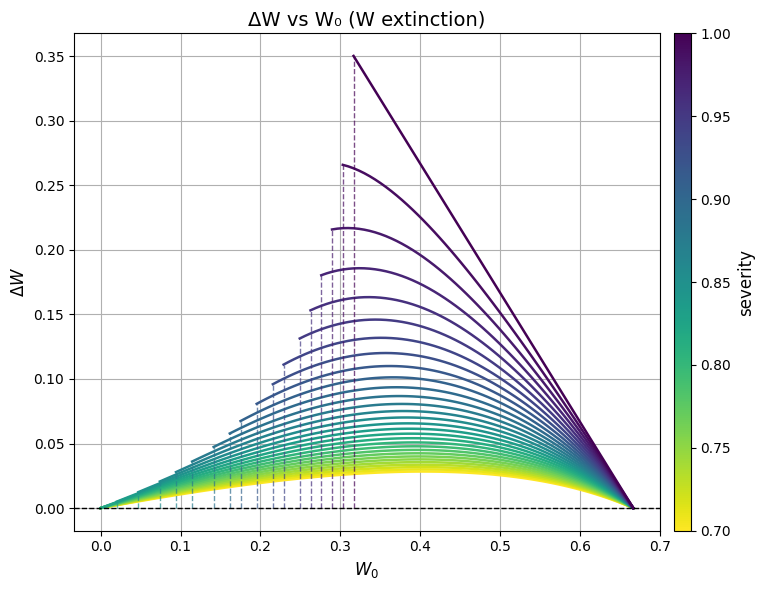

'test_plot(\n    W_birth=W_birth, Y_birth=Y_birth,\n    W_death=W_death, Y_death=Y_death,\n    X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,\n    W0=0.01,\n    Time=200.0, dt=0.01,\n    use_X=use_X, use_Z=use_Z,\n    severity=0.96842105,  # actual shock multiplier = (1 - 0.3) = 0.7\n     perturb_W=False, perturb_Y=True,\n    perturb_time=20.0,\n    tol=1e-6\n)'

In [12]:
    # Compare severities
x = compare_severities(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        Time=Time, dt=dt, use_X=use_X, use_Z=use_Z,
        num_points=num_points,
        severity_range=(0.7, 1), n_sev=30,
         perturb_W=True, perturb_Y=False,
        tol=1e-6, verbose=False
    )

    # Test‐plot at W0 = 0.1, with severity interpreted as 1−severity
'''test_plot(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        W0=0.01,
        Time=200.0, dt=0.01,
        use_X=use_X, use_Z=use_Z,
        severity=0.96842105,  # actual shock multiplier = (1 - 0.3) = 0.7
         perturb_W=False, perturb_Y=True,
        perturb_time=20.0,
        tol=1e-6
    )'''

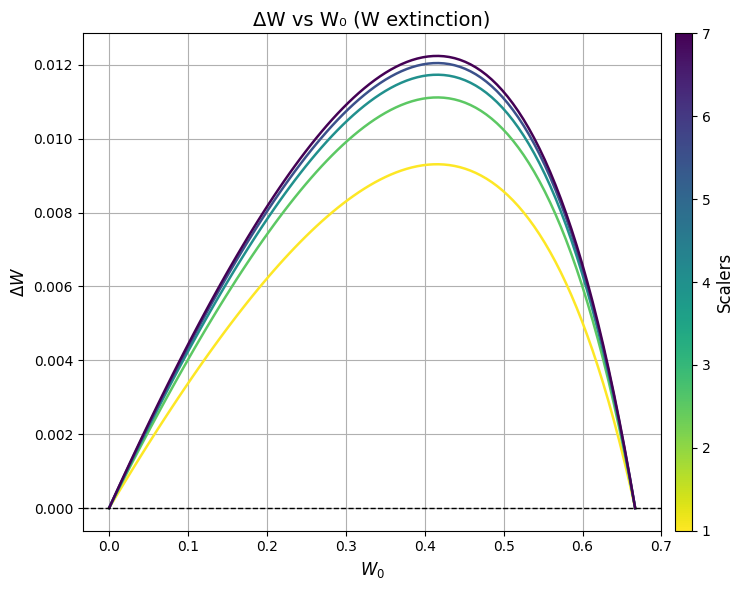

In [3]:
compare_scalers(W_birth, Y_birth, W_death, Y_death,
                       X_in, Z_in, X_out, Z_out, severity=severity,
                       Time=Time, dt=dt,
                       use_X=use_X, use_Z=use_Z, scale_X=True,
                       num_points=num_points,
                       scaler_range=(1, 7), n_scaler=5,
                       perturb_W=True, perturb_Y=False,
                       tol=1e-7,
                       verbose=False)

W0 = 0.01, V0 = 0.6566666666666666, Y0 = 0.7500000000000002, X0 = 0.02, Z0 = 0.7500000000000002
Saved run_cycles plot to run_cycles/run_cycles7.pdf


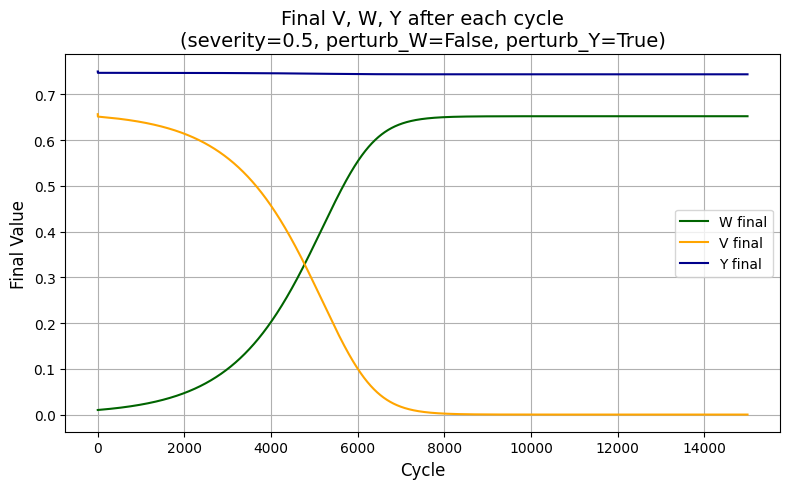

Saved run_cycles_ext plot to run_cycles_ext/run_cycles_ext7.pdf


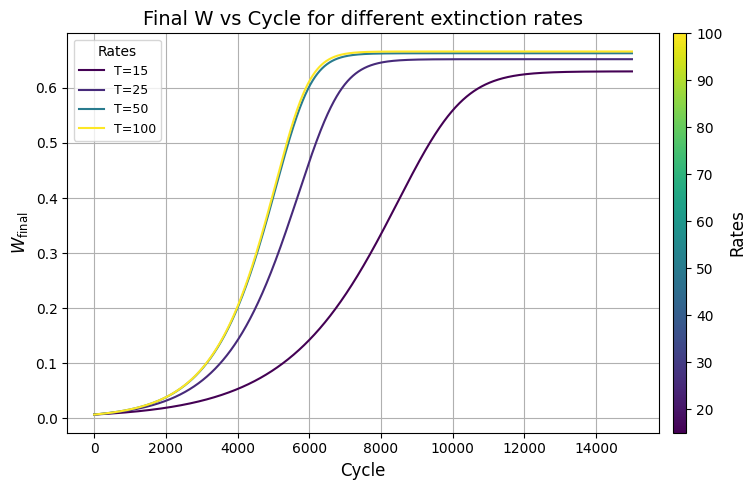

In [8]:
cycles = 15000
extinction_rate = 25.0
W0 = 0.01
X0 = W0 / (X_out / X_in)

W,Y = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
V0 = W - W0
Y0 = Y
Z0 = Y0

print(f'W0 = {W0}, V0 = {V0}, Y0 = {Y0}, X0 = {X0}, Z0 = {Z0}')

x = run_cycles(V0, W0, Y0, X0, Z0,
               W_birth, Y_birth, W_death, Y_death,
               X_in, Z_in, X_out, Z_out,
               extinction_rate, dt,
               use_X, use_Z,
               cycles,
               severity,
               perturb_W=False,
               perturb_Y=True)

x = run_cycles_ext(V0, W0, Y0, X0, Z0,
               W_birth, Y_birth, W_death, Y_death,
               X_in, Z_in, X_out, Z_out,
               extinction_rates = [15, 25, 50, 100], dt = dt,
               use_X= use_X, use_Z = use_Z,
               cycles=
               cycles,
               severity = severity,
               perturb_W=False,
               perturb_Y=True)